In [59]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
import keras
#from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split

In [23]:
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"
output_folder_path = "../../../../temp/buffers/"

## 1. Training and validation

In [41]:
# Helper functions

def sampling(src, dest, num_samples, seed=42):
    """  
    Sample NUM_SAMPLES of data from SRC and copy them to DEST.
    Set random seed to be SEED.
    """
    np.random.seed(seed)
    all_data_lst = np.array(os.listdir(src))
    n = len(all_data_lst)
    sample_indices = np.random.choice(np.arange(n), num_samples, replace=False)
    sample_files = all_data_lst[sample_indices]

    for file in sample_files:
        shutil.copy(os.path.join(src, file),
                    dest)
    print('copied samples to {}'.format(dest))

def pad_for_detector(input_x, kernel_size):
    """ Pad the input matrix such that the (i, k) entry of the output 
        matrix is the score of motif detector k aligned to position i.
    input_x has shape = (N, n, 4)
    kernel_size has shape m
    output has shape = (N, n + 2m - 2, 4)
    """
    N, n, C = input_x.shape
    pad_value, num_pad = 0.25, kernel_size - 1
    pad_matrix = np.full((N, num_pad, C), pad_value)
    return np.concatenate((pad_matrix, input_x, pad_matrix), axis=1)

def one_hot_encoding(input_folder_path, output_file_path, 
                     max_file_num=10000):
    """
    Given the data in INPUT_FOLDER_PATH, encode them and save
    as a buffer called OUTPUT_FILE_PATH.
    
    Note: INPUT_FOLDER_PATH is a directory while OUTPUT_FILE_PATH
          is a file.
    """
    import os
    # Use the following dictionary to perform the transformation
    base_pairs = {'A': [1, 0, 0, 0], 
                  'C': [0, 1, 0, 0],
                  'G': [0, 0, 1, 0],
                  'T': [0, 0, 0, 1],
                  'a': [1, 0, 0, 0],
                  'c': [0, 1, 0, 0],
                  'g': [0, 0, 1, 0],
                  't': [0, 0, 0, 1],
                  'n': [0, 0, 0, 0],
                  'N': [0, 0, 0, 0]}

    file_num_limit = max_file_num    # The maximum number of files to be decoded
    file_count = 0

    # Iterate through every file
    all_regions = []
    for file in os.listdir(input_folder_path):
        # When the number of file decoded has reached the limit, stop
        if file_count < file_num_limit:
            #print(input_folder_path + file)
            data = list(SeqIO.parse(input_folder_path + file,"fasta"))
            for n in range(0, len(data)):
                # Extract the header information
                header = data[n].description.split('|')
                descr = data[n].description
                regionID = header[0]
                expressed = header[1]
                speciesID = header[2]
                strand = header[3]
                # Complement all sequences in the negative DNA strand
    #             if strand == '-':
    #                 # Using the syntax [e for e in base_pairs[n]] to create a new pointer for each position
    #                 one_hot.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq.complement()]])
    #             else:
                all_regions.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq]])
            file_count += 1

    with open(output_file_path, mode="wb") as output:
        print("save to {}".format(output_file_path))
        pickle.dump(all_regions, output)
    return all_regions

def get_training_data(input_data, output_folder_path,
                      max_len, train_x_name, train_y_name):
    """ 
    Convert INPUT_DATA to ready-to-be-fed training data and 
        corresponding labels.
    Save them to OUTPUT_FOLDER_PATH with name TRAIN_X_NAME and
        TRAIN_Y_NAME.
    INPUT_DATA is directly generated by the function one_hot_encoding. 
    """
    train_x, train_y = [], []
    for region in input_data:
        y, x = int(region[1]), region[3]
        x = curtail(x, max_len)  # Curtail
        x = np.array(x).flatten() # Flatten
        x = x.reshape((1000, 4)) # Reshape
        train_x.append(x)
        train_y.append(y)

    train_x, train_y = np.array(train_x), np.array(train_y)

    print(train_x.shape, train_y.shape)

    with open(os.path.join(output_folder_path, train_x_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_x_name)))
        pickle.dump(train_x, output)

    with open(os.path.join(output_folder_path, train_y_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_y_name)))
        pickle.dump(train_y, output)
    return train_x, train_y

def data_split(data_x, data_y, val_split=0.2, seed=42):
    """
    Given totally N data, randomly sample N*VAL_SPLIT of them 
        to form validation data.
    Set random seed to SEED.
    """
    # Split it into training and validation data sets
    N = data_x.shape[0]
    num_val = int(N * val_split)

    np.random.seed(seed)
    val_indices = np.random.choice(np.arange(N), num_val, replace=False)
    train_indices = np.arange(N)[~np.isin(np.arange(N), val_indices)]

    train_x, train_y = data_x[train_indices], data_y[train_indices]
    val_x, val_y = data_x[val_indices], data_y[val_indices]

    print(N, train_x.shape, train_y.shape, val_x.shape, val_y.shape)
    return train_x, train_y, val_x, val_y


def dianostic_plots(train_acc, train_loss, val_train_acc, val_loss):
    """  Plot dianostic plots of a model:
    Plot 1: Traning loss & validation loss against epochs
    Plot 2: Training acc & validation acc against epochs
    """
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, '-', label='Training train_accuracy')
    plt.plot(epochs, val_train_acc, '-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoches')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, '-', label='Training Loss')
    plt.plot(epochs, val_loss, '-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoches')
    plt.legend()
    
    plt.show()

In [38]:
input_folder_path = "../../../../temp/samples/"
output_folder_path = "../../../../temp/buffers/"

# This should be the parent folder of motif files
motif_folder_path = "../../../..Map_Motif_no_threshold_14Nov2018/"

# The shelve with motif as the outermost key
motif_species_shelve_path = "../../../../temp/formatted/motif_dic"

# The shelve with species name as the outermost key
species_motif_shelve_path = "../../../../temp/formatted/species_motif_dic"
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

In [42]:
!rm -r /home/ubuntu/data/temp/samples
!mkdir /home/ubuntu/data/temp/samples

In [43]:
all_data_lst = np.array(os.listdir(data_dir))
num_samples = 209

sampling(data_dir, input_folder_path, num_samples, seed = 189)

output_file_path = os.path.join(output_folder_path, 'train.data')
train_regions = one_hot_encoding(input_folder_path, output_file_path)

data_x, data_y = get_training_data(train_regions, output_folder_path,
                                   max_len = 1000, 
                                   train_x_name = 'train_x.data', 
                                   train_y_name = 'train_y.data')

train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)

copied samples to ../../../../temp/samples/
save to ../../../../temp/buffers/train.data
(5016, 1000, 4) (5016,)
save to ../../../../temp/buffers/train_x.data
save to ../../../../temp/buffers/train_y.data
5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [55]:
train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

In [61]:
def get_hybrid(opt):
    """  Return a hybrid network given a optimizer
    """
    model = Sequential()
    model.add(Conv1D(filters = 30, 
                     kernel_size = 15, 
                     padding = 'valid',
                     data_format = 'channels_last',
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 5, strides = 5))
    model.add(Dropout(0.6))
    model.add(Bidirectional(LSTM(10)))
    model.add(Dropout(0.7))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model

def train(model, train_x, train_y, val_data, config = {'epochs': 35, 'batch_size': 256}):
    """  Train model for a given config, training data, and validation data
    """
    epochs, batch_size = config['epochs'], config['batch_size']
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=val_data)

In [62]:
# Start training
# Set up some configurations
optimizers = {'adam': Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),
              'rmsprop': RMSprop(lr=1e-2, rho=0.9, epsilon=None, decay=1e-2)}
config = {'epochs': 35, 'batch_size': 256}
opt = optimizers['rmsprop']
model = get_hybrid(opt)
history = train(model, train_x, train_y, (val_x, val_y), config)

Train on 4013 samples, validate on 1003 samples
Epoch 1/35
4013/4013 [==============================] - 16s 4ms/step - loss: 0.6988 - acc: 0.5081 - val_loss: 0.6935 - val_acc: 0.5095
Epoch 2/35
4013/4013 [==============================] - 13s 3ms/step - loss: 0.6898 - acc: 0.5293 - val_loss: 0.6740 - val_acc: 0.5852
Epoch 3/35
4013/4013 [==============================] - 12s 3ms/step - loss: 0.6846 - acc: 0.5405 - val_loss: 0.6718 - val_acc: 0.5214
Epoch 4/35
4013/4013 [==============================] - 13s 3ms/step - loss: 0.6747 - acc: 0.5432 - val_loss: 0.6516 - val_acc: 0.6171
Epoch 5/35
4013/4013 [==============================] - 12s 3ms/step - loss: 0.6701 - acc: 0.5709 - val_loss: 0.6681 - val_acc: 0.5583
Epoch 6/35
4013/4013 [==============================] - 12s 3ms/step - loss: 0.6694 - acc: 0.5647 - val_loss: 0.6554 - val_acc: 0.6560
Epoch 7/35
4013/4013 [==============================] - 13s 3ms/step - loss: 0.6585 - acc: 0.5878 - val_loss: 0.6555 - val_acc: 0.5922
Epoch 8

In [63]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net2.h5'
model.save(os.path.join(save_model_path, model_name))

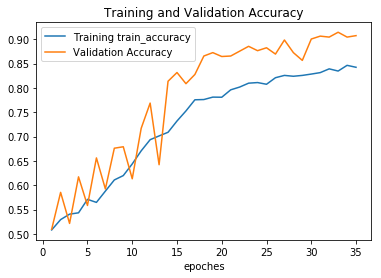

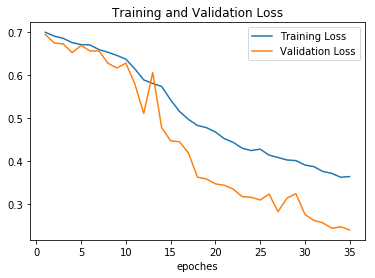

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dianostic_plots(acc, loss, val_acc, val_loss)

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1014, 30)          1830      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 202, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 202, 30)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total para

## 2. Retrieve motif from kernel

In [66]:
def get_activated_subseq(activations, test_seq, m):
    #################################################################
    # Extract those in the TEST_SEQUENCE that has least one position
    #     having positive activation.
    #################################################################
    N, L, C = activations.shape
    activated_subseq = {}
    for i in range(C): # for each filter
        activated_subseq[i] = []
        activation = activations[:, :, i]
        
        # candidate and potential_start has a shape (N, )
        candidate, potential_start = np.max(activation, axis=1), np.argmax(activation, axis=1)
        
        # activated_indices should have a shape (K, ), where K = # of positive activations
        activated_indices = [i for i in range(N) if candidate[i] > 0]
        K = len(activated_indices)
        
        # activated_seq should have a shape(K, n + 2m - 2, 4)
        activated_seq, ends = test_seq[activated_indices, :, :], potential_start[activated_indices]
        starts = ends - m + 1
        for k in range(K):
            start, end = starts[k], ends[k]
            activated_subseq[i].append(activated_seq[k, start:(end+1), :])
    return activated_subseq

In [67]:
model = load_model('../../models/hybrid_net2.h5')

filters = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

In [68]:
N, n, m = 100, 1000, 15
val_x.shape

(1003, 1028, 4)

In [70]:
layer_name = model.layers[0].get_config()['name']
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(val_x)

In [71]:
intermediate_output.shape

(1003, 1014, 30)

In [73]:
activated_subseq = get_activated_subseq(intermediate_output, val_x, m)

In [74]:
activated_subseq[0][0]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [75]:
def convert_to_car(one_hot_code):
    char_to_code = {'A': np.array([1, 0, 0, 0]),
                    'C': np.array([0, 1, 0, 0]),
                    'G': np.array([0, 0, 1, 0]),
                    'T': np.array([0, 0, 0, 1]),
                    'N': np.array([0.25, 0.25, 0.25, 0.25])}
    for char in ['A', 'C', 'G', 'T', 'N']:
        if sum(char_to_code[char] - one_hot_code) == 0:
            return char

def get_pwm(activated_subseq):
    pwm = {}
    for i in range(m):
        subseqs = activated_subseq[i]
        counter = {char: 0 for char in ['A', 'C', 'G', 'T']}
        for j in range(len(subseqs)):
            subseq = list(subseqs[j])
            for code in subseq:
                c = convert_to_car(code)
                counter[c] += 1
        pwm[i] = counter.copy()
    return pwm